In [1]:
import os
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import keras.preprocessing.image
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, DepthwiseConv2D, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, MaxPool2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

In [2]:
dataset_path = "tensorflow/dataset"
os.listdir(dataset_path)

['drowsy', 'nondrowsy']

In [3]:
print('drowsy  :',len(os.listdir("tensorflow/dataset/drowsy")))
print('nondrowsy :',len(os.listdir("tensorflow/dataset/nondrowsy")))

drowsy  : 250
nondrowsy : 250


In [4]:
# Load the dataset
data = []
labels = []

# Iterate through the dataset path and load the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        data.append(image)
        labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

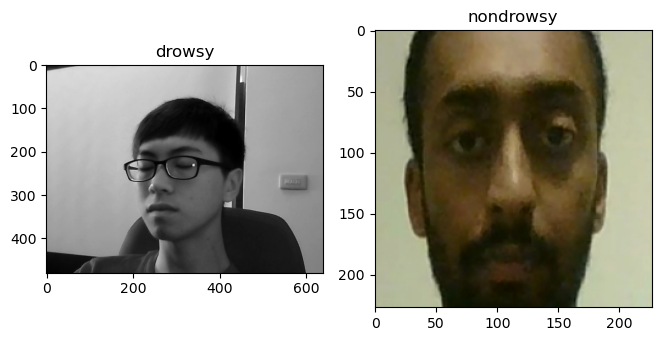

In [5]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


# Get a list of images in each grade folder
grade1_images = os.listdir(os.path.join(dataset_path, "drowsy"))
grade2_images = os.listdir(os.path.join(dataset_path, "nondrowsy"))

# Choose a random sample from each grade
sample_grade1 = random.choice(grade1_images)
sample_grade2 = random.choice(grade2_images)

# Load and display the sample images
sample1_path = os.path.join(dataset_path, "drowsy", sample_grade1)
sample2_path = os.path.join(dataset_path, "nondrowsy", sample_grade2)

sample1_img = cv2.imread(sample1_path)
sample2_img = cv2.imread(sample2_path)

# Convert BGR to RGB
sample1_img = cv2.cvtColor(sample1_img, cv2.COLOR_BGR2RGB)
sample2_img = cv2.cvtColor(sample2_img, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample1_img)
plt.title("drowsy")

plt.subplot(1, 3, 2)
plt.imshow(sample2_img)
plt.title("nondrowsy")

plt.tight_layout()
plt.show()


In [6]:
class_names = label_encoder.classes_

In [7]:
# Display the class names
print("Class Names:", class_names)

Class Names: ['drowsy' 'nondrowsy']


In [8]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [10]:
# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalize pixel values
)

In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation

In [12]:
# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [13]:
# Load MobileNet base model (excluding top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

C:\Users\Tobias\AppData\Local\Temp\ipykernel_10628\1416666862.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [14]:
model = models.Sequential([
    base_model,
    DepthwiseConv2D(kernel_size=4, strides=1, padding='same', activation=None),
    BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 5, 5, 1280)          │          21,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 5, 5, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,287,426 (8.73 MB)

 Trainable params: 26,882 (105.01 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=3)
]

In [17]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

C:\Users\Tobias\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.5704 - loss: 0.6702 - val_accuracy: 0.6400 - val_loss: 0.6779 - learning_rate: 1.0000e-04
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.7921 - loss: 0.4957 - val_accuracy: 0.6400 - val_loss: 0.6626 - learning_rate: 1.0000e-04
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.8738 - loss: 0.3960 - val_accuracy: 0.7000 - val_loss: 0.6500 - learning_rate: 1.0000e-04
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.9164 - loss: 0.3346 - val_accuracy: 0.7600 - val_loss: 0.6374 - learning_rate: 1.0000e-04
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.8811 - loss: 0.3343 - val_accuracy: 0.7600 - val_loss: 0.6271 - learning_rate: 1.0000e-04
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8947 - loss: 0.2969 - val_accuracy: 0.8000 - val_loss: 0.6160 - learning_rate: 1.0000e-04
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 

In [18]:
# Evaluation
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8120 - loss: 0.4492 
Validation Accuracy: 84.00%


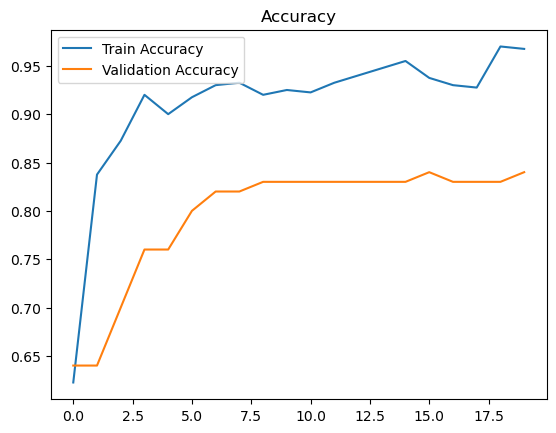

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

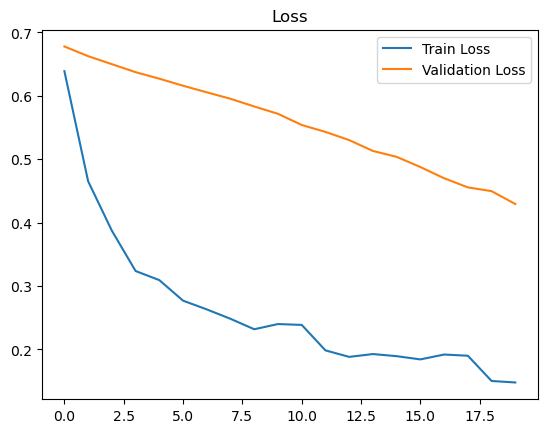

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Normalize the test data (same as training)
X_test = X_test / 255.0

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step


In [22]:
# Convert one-hot encoded y_test back to class indices if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test  # If already in class index format

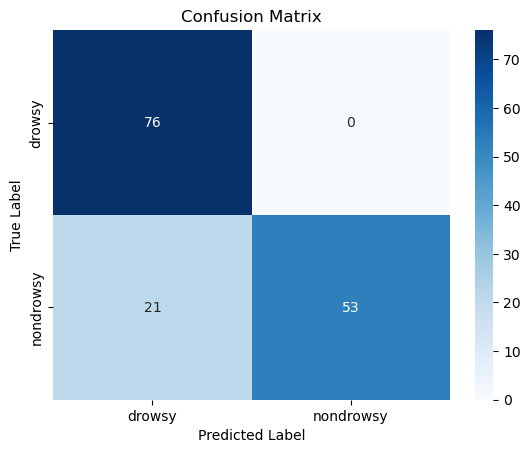

In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      drowsy       0.78      1.00      0.88        76
   nondrowsy       1.00      0.72      0.83        74

    accuracy                           0.86       150
   macro avg       0.89      0.86      0.86       150
weighted avg       0.89      0.86      0.86       150

